In [1]:
! pip install yellowbrick


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [7]:
# PEP8-friendly imports groupés
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
# Version business (brute, non standardisée) pour l’interprétation des clusters
rfm_business = pd.read_csv("olist_customers_features.csv", index_col=0)

# Version standardisée pour le ML (entrée des algos)
X_scaled = pd.read_csv("olist_customers_features_scaled.csv", index_col=0)
X = X_scaled.values

In [3]:
display(rfm_business.head())
display(X_scaled.describe())
print("Shape:", X_scaled.shape)

,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
customer_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,5.0,6.411227
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4.0,3.285590
0000f46a3911fa3c0805444483337064,538,1,86.22,3.0,25.731759
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,4.0,20.037083
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,5.0,13.141134


,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
count,9.335800e+04,9.335800e+04,9.335800e+04,9.335800e+04,9.335800e+04
mean,-9.095081e-17,6.050702e-17,2.191953e-17,-4.871006e-18,-5.396161e-17
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.556524e+00,-1.598294e-01,-7.299499e-01,-2.471486e+00,-1.260677e+00
25%,-8.094540e-01,-1.598294e-01,-4.513421e-01,-1.204085e-01,-6.054050e-01
50%,-1.213630e-01,-1.598294e-01,-2.537064e-01,6.632840e-01,-2.443708e-01
75%,7.108993e-01,-1.598294e-01,7.671019e-02,6.632840e-01,3.299748e-01
max,3.115941e+00,6.679496e+01,5.964701e+01,6.632840e-01,2.064395e+01


Shape: (93358, 5)


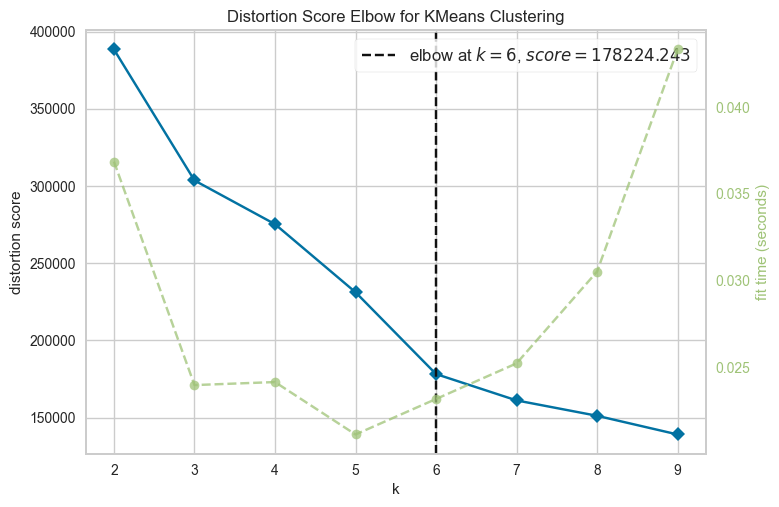

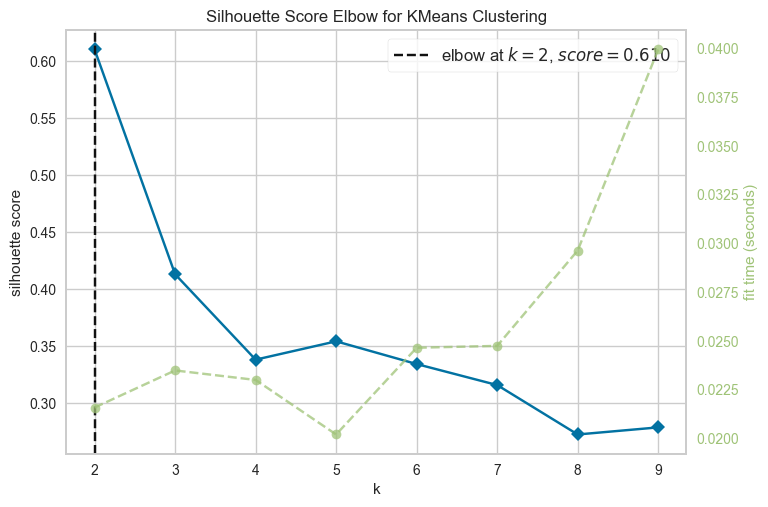

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [8]:
# --- Elbow method ---
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion')  # inertia
visualizer.fit(X)
visualizer.show()

# --- Silhouette method ---
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')
visualizer.fit(X)
visualizer.show()

,k,inertia,silhouette,calinski_harabasz,davies_bouldin,min_cluster_size,max_cluster_size
0,2,380369,0.390,21211,1.420,16504,76854
1,3,303564,0.415,25098,1.110,2808,74668
2,4,246415,0.310,27830,1.074,2807,42925
3,5,203130,0.327,30293,0.978,2009,42050
4,6,178224,0.335,30230,0.986,1959,40278
5,7,161169,0.315,29503,0.997,1866,31893
6,8,148875,0.318,28478,0.970,419,31286
7,9,139115,0.277,27485,0.994,412,25694
8,10,129643,0.278,26973,0.987,227,25668


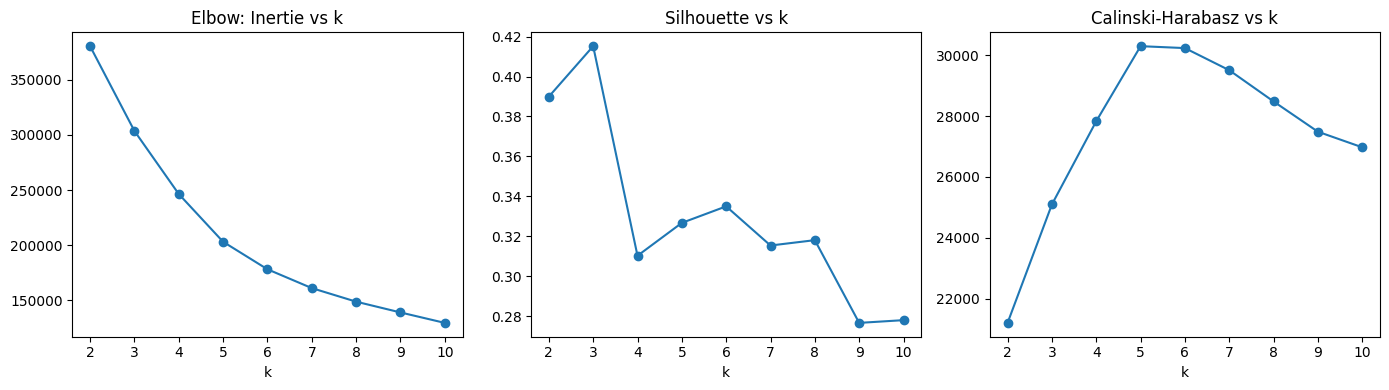

In [4]:
rows = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    inertia = km.inertia_
    sil = silhouette_score(X, labels, sample_size=min(20000, len(X)), random_state=42)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    sizes = np.bincount(labels)
    rows.append({
        "k": k, "inertia": inertia, "silhouette": sil,
        "calinski_harabasz": ch, "davies_bouldin": db,
        "min_cluster_size": sizes.min(), "max_cluster_size": sizes.max()
    })

scores = pd.DataFrame(rows)
display(scores.style.format({"inertia":"{:.0f}", "silhouette":"{:.3f}", "calinski_harabasz":"{:.0f}", "davies_bouldin":"{:.3f}"}))

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].plot(scores["k"], scores["inertia"], marker="o"); ax[0].set_title("Elbow: Inertie vs k"); ax[0].set_xlabel("k")
ax[1].plot(scores["k"], scores["silhouette"], marker="o"); ax[1].set_title("Silhouette vs k"); ax[1].set_xlabel("k")
ax[2].plot(scores["k"], scores["calinski_harabasz"], marker="o"); ax[2].set_title("Calinski-Harabasz vs k"); ax[2].set_xlabel("k")
plt.tight_layout(); plt.show()

In [9]:
def describe_clusters(labels, df_business, cols=None):
    out = df_business.copy()
    out["cluster"] = labels
    if cols is None:
        cols = ["recency_days","frequency","monetary","avg_review_score","avg_delivery_delay"]
    desc = out.groupby("cluster")[cols].mean().round(2)
    sizes = out["cluster"].value_counts().sort_index()
    return desc, sizes

# k=3
km3 = KMeans(n_clusters=3, random_state=42, n_init=20).fit(X)
desc3, sizes3 = describe_clusters(km3.labels_, rfm_business)
print("K=3 — silhouette:", silhouette_score(X, km3.labels_))
display(sizes3.to_frame("count")); display(desc3)

# k=4
km4 = KMeans(n_clusters=4, random_state=42, n_init=20).fit(X)
desc4, sizes4 = describe_clusters(km4.labels_, rfm_business)
print("K=4 — silhouette:", silhouette_score(X, km4.labels_))
display(sizes4.to_frame("count")); display(desc4)

# k=5
km5 = KMeans(n_clusters=5, random_state=42, n_init=20).fit(X)
desc5, sizes5 = describe_clusters(km5.labels_, rfm_business)
print("K=5 — silhouette:", silhouette_score(X, km5.labels_))
display(sizes5.to_frame("count")); display(desc5)

# k=6
km6 = KMeans(n_clusters=6, random_state=42, n_init=20).fit(X)
desc6, sizes6 = describe_clusters(km6.labels_, rfm_business)
print("K=6 — silhouette:", silhouette_score(X, km6.labels_))
display(sizes6.to_frame("count")); display(desc6)

K=3 — silhouette: 0.4129621802989263


,count
cluster,
0,74668
1,2808
2,15882


,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
cluster,,,,,
0,237.58,1.00,153.00,4.65,10.60
1,220.85,2.11,325.88,4.20,12.34
2,246.07,1.00,194.14,1.79,21.87


K=4 — silhouette: 0.3088924981769639


,count
cluster,
0,33265
1,42925
2,14361
3,2807


,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
cluster,,,,,
0,390.99,1.00,155.96,4.59,11.73
1,123.27,1.00,152.23,4.64,9.94
2,233.26,1.00,194.23,1.66,22.41
3,220.92,2.11,324.39,4.20,12.35


K=5 — silhouette: 0.32550165456093455


,count
cluster,
0,14011
1,2772
2,32516
3,2009
4,42050


,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
cluster,,,,,
0,233.26,1.00,157.01,1.66,22.40
1,221.00,2.11,289.68,4.21,12.33
2,391.17,1.00,134.23,4.59,11.69
3,235.93,1.02,1252.73,4.11,14.06
4,123.51,1.00,131.71,4.64,9.92


K=6 — silhouette: 0.3342499121929497


,count
cluster,
0,31318
1,40278
2,5097
3,2770
4,11936
5,1959


,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
cluster,,,,,
0,393.06,1.00,134.51,4.65,11.60
1,122.19,1.00,131.79,4.71,9.90
2,240.84,1.00,170.76,2.09,39.23
3,221.03,2.11,289.76,4.21,12.29
4,229.19,1.00,147.12,1.84,12.64
5,235.25,1.02,1262.09,4.14,13.53


## Lecture des 6 clusters

	Cluster 0
		•	Très anciens (393 j), achat unique, faible dépense (134 €), reviews excellentes (4.65), délai correct (11 j).
	→ Clients anciens mais satisfaits → profil à réactiver.


	Cluster 1
		•	Très récents (122 j), achat unique, faible dépense (132 €), reviews excellentes (4.71), délais rapides (10 j).
	→ Nouveaux clients satisfaits → à fidéliser dès maintenant.


	Cluster 2
		•	Moyennement récents (241 j), achat unique, faible dépense (171 €), reviews mauvaises (2.1), délais catastrophiques (39 j).
	→ One-shot très insatisfaits → fort risque de churn (peu récupérables).


	Cluster 3
		•	Clients réguliers (2.1 achats), dépense moyenne (290 €), reviews correctes (4.2), délais normaux (12 j).
	→ Bons clients standards → cœur de cible.


	Cluster 4
		•	Moyennement récents (229 j), achat unique, faible dépense (147 €), reviews mauvaises (1.84), délais médiocres (12.6 j).
	→ One-shot insatisfaits (modérés) → un cran en dessous du cluster 2 (moins extrême).


	Cluster 5
		•	Moyennement récents (235 j), dépense énorme (1260 €), reviews correctes (4.1), délais moyens (13 j).
	→ Clients premium / gros acheteurs → programme VIP / cross-sell.

In [4]:
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
agg_labels = agg.fit_predict(X)
sil = silhouette_score(X, agg_labels)
print(f"Agglo Ward k={3}: silhouette={sil:.3f}")
desc, sizes = describe_clusters(agg_labels, rfm_business)
display(sizes.to_frame("count")); display(desc)

: 

In [4]:
db = DBSCAN(eps=0.5, min_samples=10)  # à tuner
db_labels = db.fit_predict(X)
unique, counts = np.unique(db_labels, return_counts=True)
print(dict(zip(unique, counts)))  # -1 = bruit
# silhouette sur DBSCAN seulement si au moins 2 clusters valides
if len(unique[unique!=-1]) >= 2:
    print("Silhouette DBSCAN:", silhouette_score(X[db_labels!=-1], db_labels[db_labels!=-1]))

{np.int64(-1): np.int64(2293), np.int64(0): np.int64(88786), np.int64(1): np.int64(19), np.int64(2): np.int64(2020), np.int64(3): np.int64(18), np.int64(4): np.int64(109), np.int64(5): np.int64(6), np.int64(6): np.int64(29), np.int64(7): np.int64(12), np.int64(8): np.int64(9), np.int64(9): np.int64(18), np.int64(10): np.int64(11), np.int64(11): np.int64(10), np.int64(12): np.int64(11), np.int64(13): np.int64(7)}
Silhouette DBSCAN: 0.1328792411586301


🔹 Résultats bruts
	•	Cluster 0 : 88 786 points (quasi tout le dataset).
	•	Plusieurs micro-clusters (quelques dizaines de points chacun).
	•	Beaucoup de bruit : 2 293 points étiquetés -1.
	•	Silhouette globale (hors bruit) : 0.13 → très faible.


🔹 Interprétation
	•	DBSCAN n’a pas trouvé de structure “naturelle” claire.
	•	Paramètres actuels (eps=0.5, min_samples=10) → produisent un cluster géant + du bruit + des micro-groupes.
	•	Le score silhouette ≈ 0.13 confirme que la partition n’est pas exploitable.


🔹 Pourquoi ?
	1.	Données sont déjà très denses et homogènes (après standardisation). DBSCAN a du mal dans ce cas : il préfère les structures avec densités bien contrastées.
	2.	eps=0.5 est probablement trop petit → presque tout est regroupé dans un seul cluster.
	3.	DBSCAN est sensible à l’échelle et à la distribution → il marche bien pour détecter des outliers ou des formes non convexes, moins bien pour segmenter un dataset client type RFM.

⸻

🔹 Conclusion
	•	k-means (k=3) reste le meilleur candidat (score silhouette correct et clusters lisibles métier).
	•	DBSCAN ici → non pertinent

In [10]:
# Modèle final (KMeans k=6)
final_labels = km6.labels_
seg = rfm_business.copy()
seg["cluster"] = final_labels
seg.to_csv("./olist_customers_segments_k6.csv")
seg.groupby("cluster")[["recency_days","frequency","monetary","avg_review_score","avg_delivery_delay"]].mean().round(2)

,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
cluster,,,,,
0,393.06,1.00,134.51,4.65,11.60
1,122.19,1.00,131.79,4.71,9.90
2,240.84,1.00,170.76,2.09,39.23
3,221.03,2.11,289.76,4.21,12.29
4,229.19,1.00,147.12,1.84,12.64
5,235.25,1.02,1262.09,4.14,13.53


Comment justifier malgré les crashs
	
    1.	Argument technique
	•	Agglomerative Clustering a une complexité en O(n²) → avec ~90k clients, ça veut dire calculer une matrice de distance de plus de 8 milliards d’éléments (≈ 64 Go mémoire).
	•	C’est inadapté en pratique sur ce volume.
	•	Tu peux dire : “Nous avons tenté Agglomerative Clustering, mais la complexité quadratique le rend impraticable sur notre volumétrie (~90 000 clients).”
	
    2.	Argument méthodologique
	•	Agglo est surtout utile pour visualiser une hiérarchie ou traiter des petits datasets.
	•	Pour de la segmentation e-commerce à grande échelle, on privilégie des méthodes plus scalables comme k-means.
	•	Tu peux noter que sur un sous-échantillon ça pourrait marcher, mais pas sur l’ensemble.
	
    3.	Argument de cohérence
	•	K-means a donné des résultats stables (k=5 ou k=6 avec segments interprétables).
	•	DBSCAN a été testé, mais ne convenait pas (clusters déséquilibrés + silhouette faible).
	•	Agglo est inapplicable en production pour ce dataset.

Donc par élimination raisonnée et par pertinence pratique, k-means est le meilleur choix.

⸻


“Nous avons comparé plusieurs approches de clustering. DBSCAN, bien que robuste pour détecter des outliers, n’a pas produit de structure exploitable sur nos données (clusters très déséquilibrés, silhouette faible). Agglomerative Clustering, en revanche, est théoriquement intéressant pour visualiser une hiérarchie, mais sa complexité O(n²) le rend impraticable sur notre volumétrie (~90 000 clients), provoquant des crashs mémoire. K-means, au contraire, est scalable, a fourni des clusters stables et interprétables (5 à 6 segments clients distincts), et constitue donc la meilleure méthode dans ce contexte.”